In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import os, random

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
all_df = pd.read_csv('../input/fda-termproject/all_asset_2010_2020.csv')
all_df['Date'] = all_df.Date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
all_df.set_index('Date',inplace=True)

## code hide

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

class StockDataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx,:], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
    
    final_loss /= len(dataloader)
    
    return final_loss

def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

In [4]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 200
device = ('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.01

In [5]:
def run_training(df, asset_name):
    seed_everything(seed=42)
    
    stock = df[[asset_name]].resample('M').agg('last').dropna()
    scaler = MinMaxScaler().fit(stock.values.reshape(-1,1))
    stock[asset_name] = scaler.transform(stock)
    
    lookback = 12
    x_train, y_train, x_valid, y_valid = split_data(stock, lookback)
    
    train_dataset = StockDataset(x_train, y_train)
    valid_dataset = StockDataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3,
                                              max_lr=1e-2, epochs=num_epochs, steps_per_epoch=len(trainloader))

    loss_fn = torch.nn.MSELoss(reduction='mean')

    best_pred = []

    best_epoch = 0
    for epoch in range(num_epochs):
        train_loss = train_fn(model, optimizer, scheduler, loss_fn, trainloader, device)
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, device)

        best_loss = np.inf
        equiv = np.inf
        if valid_loss < best_loss:

            best_loss = valid_loss
            equiv = train_loss
            best_pred.append(valid_preds)
            best_epoch = epoch

    
    print(f'BEST EPOCH: {epoch}, train_loss: {equiv:.5f}, valid_loss :{valid_loss:.5f}')
    
    inverse_y = scaler.inverse_transform(y_valid)
    inverse_y_hat = scaler.inverse_transform(best_pred[-1])
    
    return inverse_y, inverse_y_hat

In [6]:
price, price_pred =run_training(all_df, 'AAPL')

BEST EPOCH: 199, train_loss: 0.00028, valid_loss :0.00708


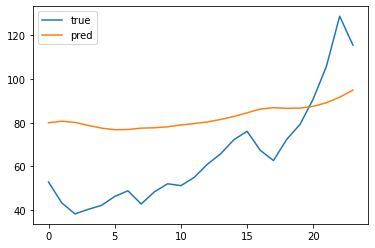

In [7]:
fig, ax = plt.subplots(1,1)
ax.plot(price, label='true')
ax.plot(price_pred, label='pred')

plt.legend()
plt.show()